In [1]:
import tensorflow as tf
import numpy as np

from utils import plot_images, print_progress, merge, add_variable_histogram_summaries
from glob import glob
from os import getcwd
from os.path import exists
from time import time
from scipy.misc import imresize

In [2]:
DIR_NB = getcwd()

In [38]:
class Classifier():
    def __init__(self):
        pass
    
    def label(self, filenames):
        labels = np.zeros(len(filenames), dtype=int)
        for i, filename in enumerate(filenames):
            if filename[:filename.find('.')] == 'dog':
                labels[i] = 1
                
        return self._one_hot(labels, 2)
    
    def _one_hot(self, labels, length=None):
        if length == None:
            length = np.max(labels) + 1

        one_hot_labels = np.zeros((len(labels), length))
        one_hot_labels[range(len(labels)), labels] = 1
        
        return one_hot_labels

In [39]:
class Data():
    def __init__(self, path, classifier):
        self.path = path
        self.classifier = classifier
        self.filenames = {}
        self.num_examples = {}
        
        curr_dir = getcwd()
        for mode in ['train', 'test', 'valid']:
            %cd $path/$mode
            self.filenames[mode] = glob('*.jpg')
            self.num_examples[mode] = len(self.filenames[mode])
        %cd $curr_dir
        
    def next_batch(self, batch_size, batch=None, mode='train', dilution=0):
        if batch is None:
            batch_idx = np.random.randint(0, self.num_examples[mode], batch_size)
        else:
            batch_idx = np.arange(batch*batch_size, min((batch + 1) * batch_size, self.num_examples[mode]))
            
        x_batch = []
        for batch_id in batch_idx:
            x_batch.append(imresize(imread(self.path + '/' + mode + '/' + self.filenames[mode][batch_id]), (int(224/ np.power(2, dilution)), int(224/ np.power(2, dilution)))))
        
        y_batch = self.classifier.label(np.array(self.filenames[mode])[batch_idx])
        
        return np.stack(x_batch) / 127.5 - 1, np.stack(y_batch)

In [40]:
use_sample = False
if use_sample:
    DIR_DATA = DIR_NB + '/Data/CatDog/sample'
else:
    DIR_DATA = DIR_NB + '/Data/CatDog'
    
data = Data(DIR_DATA, Classifier())
data.num_examples

/home/vaisakh/TensorFlow-Tutorials/Data/CatDog/train
/home/vaisakh/TensorFlow-Tutorials/Data/CatDog/test
/home/vaisakh/TensorFlow-Tutorials/Data/CatDog/valid
/home/vaisakh/TensorFlow-Tutorials


{'test': 12500, 'train': 20000, 'valid': 5000}

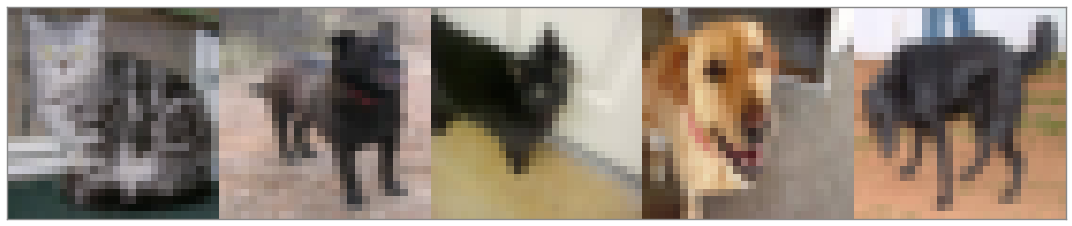

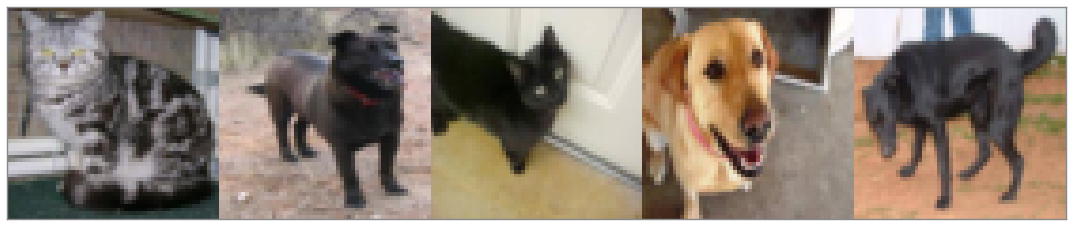

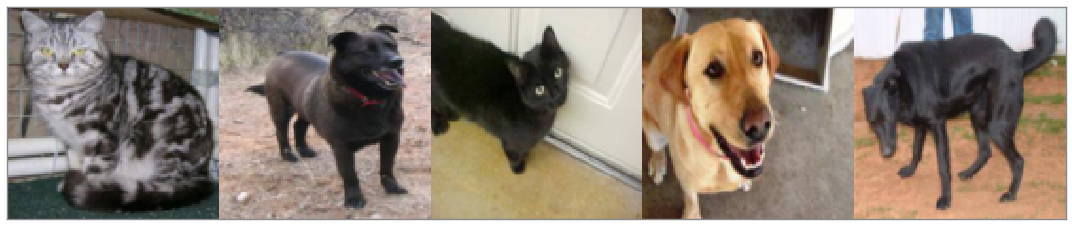

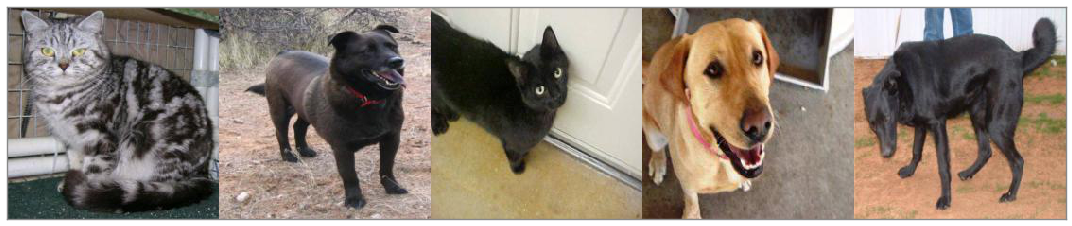

In [6]:
img_idx = randint(0, 500)
for d in range(3, -1, -1):
    plot_images((merge(data.next_batch(5, img_idx, dilution=d)[0]) + 1) / 2)

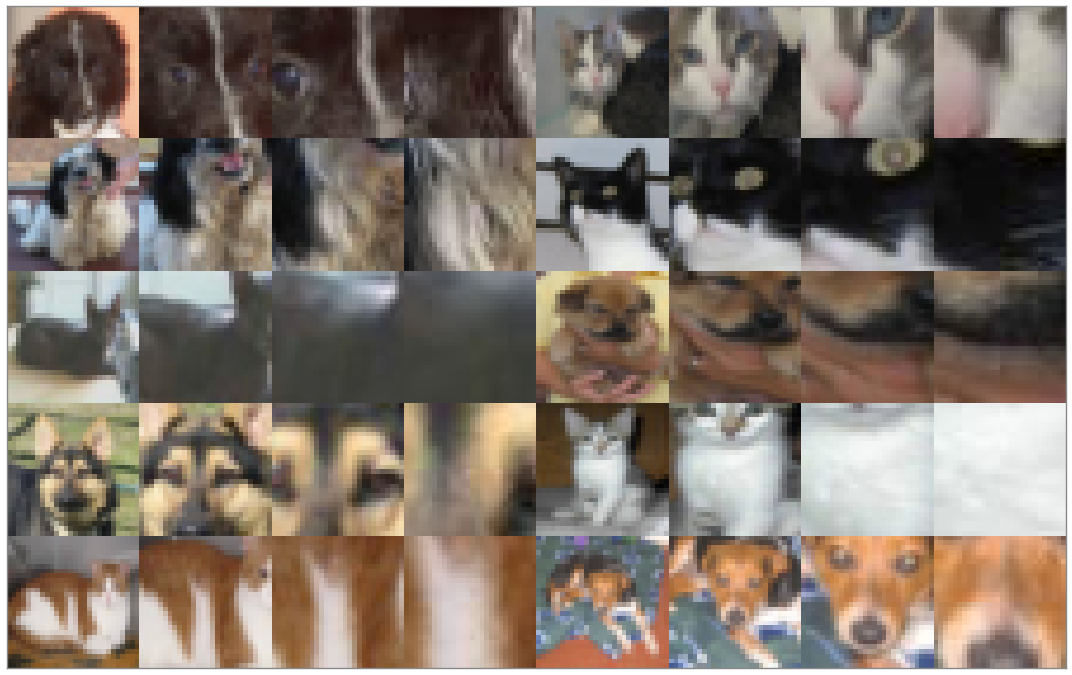

In [63]:
def enlarge(x, y, pos, dilution_gap=1):
    w, h = x.shape[:2]
    w = int(w/2)
    h = int(h/2)
    n = int(np.power(2, dilution_gap))
    return y[pos[0]*n:pos[0]*n + w*n, pos[1]*n:pos[1]*n + h*n, :]

image_list = []
for _ in range(10):
    idx = randint(0, data.num_examples['train'])
    sample_img_3 = data.next_batch(1, idx, dilution=3)[0]
    sample_img_2 = data.next_batch(1, idx, dilution=2)[0]
    sample_img_1 = data.next_batch(1, idx, dilution=1)[0]
    sample_img_0 = data.next_batch(1, idx, dilution=0)[0]
    image_list.append(sample_img_3[0]*0.5+0.5)
    pos = np.array((7, 7))
    enlarged_img_2 = enlarge(sample_img_3[0], sample_img_2[0], pos)
    image_list.append(enlarged_img_2*0.5+0.5)
    pos = 2 * pos + np.array((7, 7))
    enlarged_img_1 = enlarge(enlarged_img_2, sample_img_1[0], pos)
    image_list.append(enlarged_img_1*0.5+0.5)
    pos = 2 * pos + np.array((7, 7))
    enlarged_img_0 = enlarge(enlarged_img_1, sample_img_0[0], pos)
    image_list.append(enlarged_img_0*0.5+0.5)
plot_images(merge(np.stack(image_list)))

In [19]:
with tf.Session() as sess:
    x_batch, y_batch = data.next_batch(32, dilution=3)
    v = tf.Variable(np.random.randn(32, 2))
    sess.run(tf.global_variables_initializer())
    print(sess.run(tf.gather_nd(v, tf.transpose([tf.range(0, tf.shape(y_batch)[0]), tf.argmax(y_batch, 1, output_type=tf.int32)]))))

[-1.84598965  0.96316299  0.31949258 -0.00489551 -1.10032819  1.59257681
  2.75631332  0.70025015 -0.71431634  0.17414569  0.74212619 -1.20405689
 -0.37442906 -1.01987225  0.23509477 -0.12133554 -0.92969696 -0.14267778
 -1.04186059  0.69006299 -0.99249795  0.18142893  0.91594576 -0.80666055
 -0.17855875 -0.52123817  0.22614215  0.05442998  0.03806361  1.04567295
  0.70999501  0.0316526 ]


In [8]:
def arg_max_idx(x):
    r = tf.argmax(tf.reduce_max(x, -1), -1)
    c = tf.argmax(tf.reduce_max(x, -2), -1)
    return tf.stack([r, c], 1)

In [9]:
def classifier(x, true_label, training):
    conv = tf.layers.conv2d(x, 128, (3, 3), (2, 2), 'same', activation=tf.nn.relu, name='conv1')
    y = tf.reshape(conv, (-1, 14 * 14 * 128))
    scores = tf.layers.dense(y, 2)
    y = tf.nn.sigmoid(scores)
    y_true = tf.gather_nd(y, tf.transpose([tf.range(0, tf.shape(y)[0]), true_label]))
    dx = tf.abs(tf.gradients(y_true, x))
    dx_block = tf.reduce_mean(tf.nn.avg_pool(dx[0], (1, 14, 14, 1), (1, 1, 1, 1), 'VALID'), 3)
    pos = arg_max_idx(dx_block)
    
    return scores, dx_block, pos

In [65]:
tf.reset_default_graph()

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 28, 28, 3), 'x')
    y = tf.placeholder(tf.float32, (None, 2), 'y')
    training = tf.placeholder_with_default(True, [], 'training')
    true_label = tf.argmax(y, 1, output_type=tf.int32)
    
with tf.variable_scope('classifier'):
    scores, dx_block, pos = classifier(x, true_label, training)
    y_true = tf.nn.sigmoid(scores)

with tf.name_scope('optimizer'):
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=scores, name='cross_entropy'), name='mean')
    softloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=scores, name='cross_entropy'), name='mean')
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)

with tf.name_scope('metrics'):
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true, 1), tf.argmax(y, 1)), tf.float32))
    
tf.summary.scalar('accuracy', accuracy)
tf.summary.scalar('loss', loss)
tf.summary.scalar('softloss', softloss)
add_variable_histogram_summaries()
summ = tf.summary.merge_all()

val_accuracy_summ = tf.summary.scalar('val_accuracy', accuracy)
val_loss_summ = tf.summary.scalar('val_loss', loss)
val_softloss_summ = tf.summary.scalar('val_softloss', softloss)

saver = tf.train.Saver()

In [11]:
NB_NAME = 'CatDog-Fuzzy'
DIR_OUTPUT = DIR_NB + '/output/' + NB_NAME
DIR_WRITE = DIR_NB + '/checkpoints/' + NB_NAME

In [12]:
def write_validation_scores(sess, writer, global_step):
    x_batch, y_batch = data.next_batch(batch_size, mode='valid', dilution=3)
    cost, acc, softcost = sess.run([val_loss_summ, val_accuracy_summ, val_softloss_summ], {x: x_batch, y: y_batch, training:False})
    
    writer.add_summary(cost, global_step)
    writer.add_summary(acc, global_step)
    writer.add_summary(softcost, global_step)

In [13]:
def restore_checkpoint(sess):
    if exists(DIR_WRITE + '/' +  NB_NAME + '.data-00000-of-00001'):
        saver.restore(sess, DIR_WRITE + '/' + NB_NAME)
    else:
        sess.run(tf.global_variables_initializer())
        
    if exists(DIR_WRITE + '/epochs_completed.npy'):
        return np.load(DIR_WRITE + '/epochs_completed.npy')
    else:
        return 0

In [14]:
batch_size = 32
writes_per_epoch = 10

batches_per_epoch = int(data.num_examples['train'] / batch_size)

def optimize(epochs=1):
    start_time = time()
    writer = tf.summary.FileWriter(DIR_WRITE, tf.get_default_graph())
    
    with tf.Session() as sess:
        start_epochs = restore_checkpoint(sess)
        for epoch in range(epochs):
            epoch_start_time = time()
            print('Epoch {} started'.format(start_epochs + epoch))
            for batch in range(batches_per_epoch):
                x_batch, y_batch = data.next_batch(batch_size, dilution=3)
                feed_dict_train = {x: x_batch, y: y_batch}
                summary, _ = sess.run([summ, optimizer], feed_dict_train)
                
                if batch % int(batches_per_epoch / writes_per_epoch) == 0 or batch == batches_per_epoch-1:
                    writer.add_summary(summary, global_step=(start_epochs+epoch)*batches_per_epoch + batch)
                    write_validation_scores(sess, writer, (start_epochs+epoch)*batches_per_epoch + batch)
                
                print_progress(batch, batches_per_epoch, epoch_start_time)
            saver.save(sess, DIR_WRITE + '/' + NB_NAME, write_meta_graph=False)
        
    print("Optimization done! Time taken: {}s".format(int(time()-start_time)))
    writer.close()
    np.save(DIR_WRITE + '/epochs_completed.npy', start_epochs + epochs)

In [15]:
optimize(10)

Epoch 0 started
Completed in 26s. Time - 26s, ETA - 0s			

Epoch 1 started
Completed in 23s. Time - 23s, ETA - 0s			

Epoch 2 started
Completed in 22s. Time - 22s, ETA - 0s			

Epoch 3 started
Completed in 23s. Time - 22s, ETA - 0s			

Epoch 4 started
Completed in 22s. Time - 22s, ETA - 0s			

Epoch 5 started
Completed in 21s. Time - 21s, ETA - 0s			

Epoch 6 started
Completed in 22s. Time - 21s, ETA - 0s			

Epoch 7 started
Completed in 21s. Time - 21s, ETA - 0s			

Epoch 8 started
Completed in 21s. Time - 21s, ETA - 0s			

Epoch 9 started
Completed in 21s. Time - 21s, ETA - 0s			

Optimization done! Time taken: 228s


In [16]:
with tf.Session() as sess:
    restore_checkpoint(sess)
    cost = 0
    acc = 0
    softcost = 0
    
    for batch in range(int(data.num_examples['valid'] / batch_size)):
        x_batch, y_batch = data.next_batch(batch_size, dilution=3, mode='valid')
        add_cost, add_acc, add_softcost = sess.run([loss, accuracy, softloss], {x: x_batch, y: y_batch, training:False})
        cost += add_cost
        acc += add_acc
        softcost += add_softcost
        
    cost /= int(data.num_examples['valid'] / batch_size)
    acc /= int(data.num_examples['valid'] / batch_size)
    softcost /= int(data.num_examples['valid'] / batch_size)
    
    print("Softloss: {}, Accuracy: {}%, Loss: {}".format(softcost, np.round(acc*100, 2), cost))

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy
Softloss: 0.6998815811597384, Accuracy: 76.12%, Loss: 0.517375356111771


INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


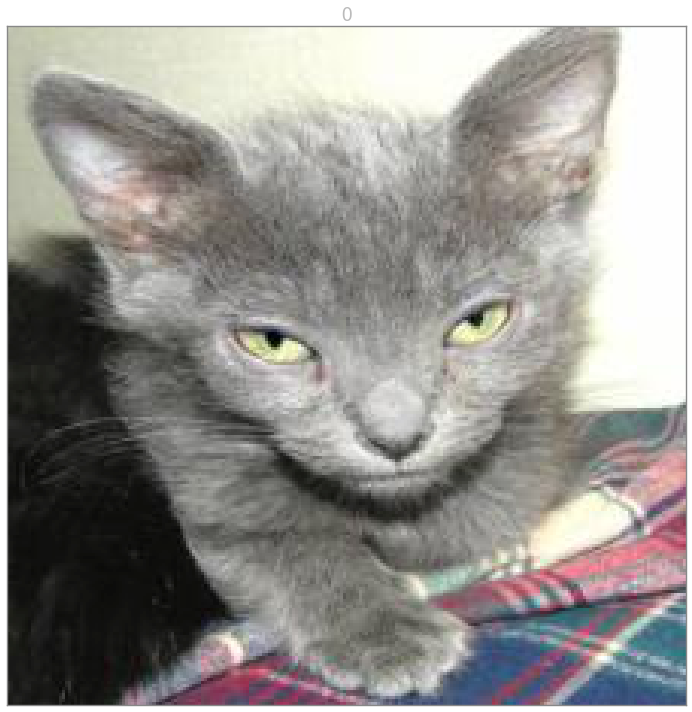

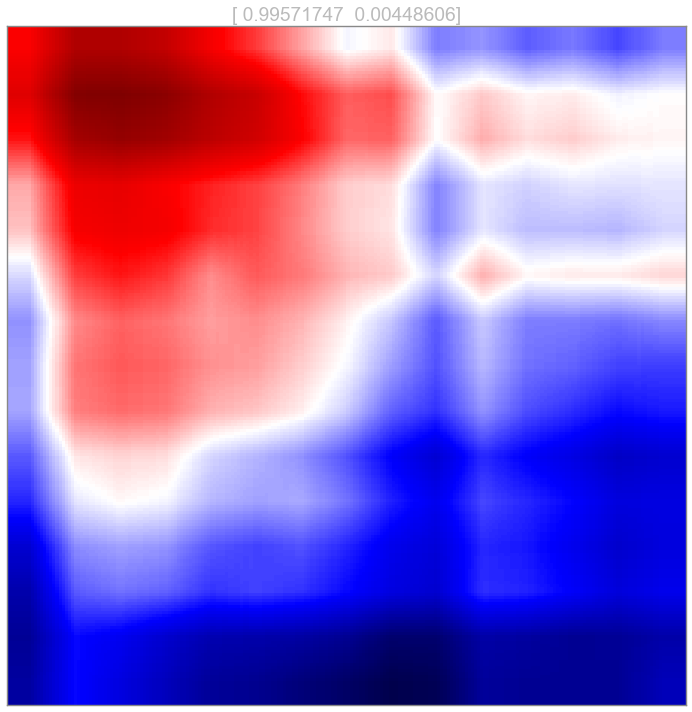

[1 2]


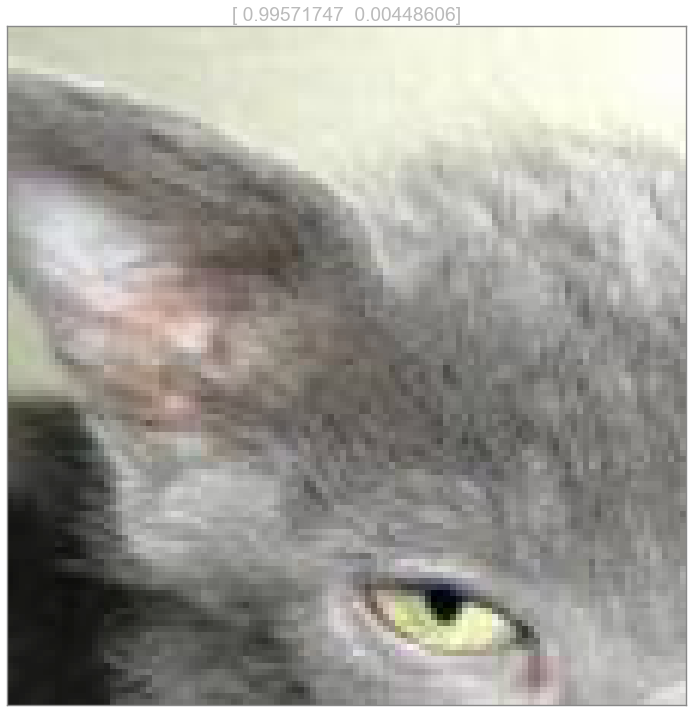

In [109]:
sample_idx = randint(0, data.num_examples['valid'], 1)
sample_img, y_batch = data.next_batch(1, sample_idx, dilution=3, mode='valid')
with tf.Session() as sess:
    restore_checkpoint(sess)
    grad_block, max_pos, label = sess.run([dx_block, pos, y_true], {x: sample_img, y: y_batch, training:False})
plot_images(data.next_batch(1, sample_idx, dilution=0, mode='valid')[0]*0.5+0.5, y_batch.argmax(1))
plot_images(np.stack([imresize(grad_block[0], (224, 224))]), label, cmap='seismic')
print(max_pos[0])
plot_images(np.stack([enlarge(sample_img[0], data.next_batch(1, sample_idx, dilution=0, mode='valid')[0][0], max_pos[0], dilution_gap=3)])*0.5+0.5, label, cmap='seismic')

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


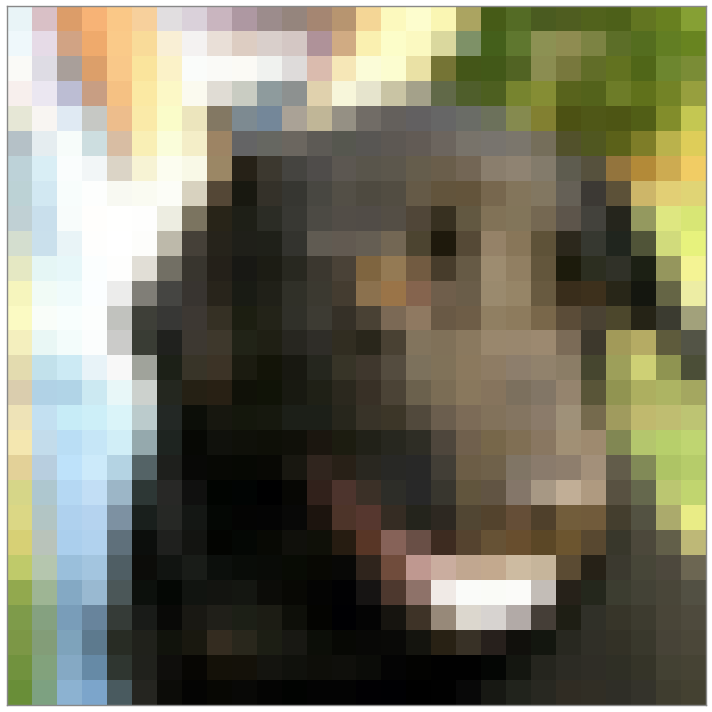

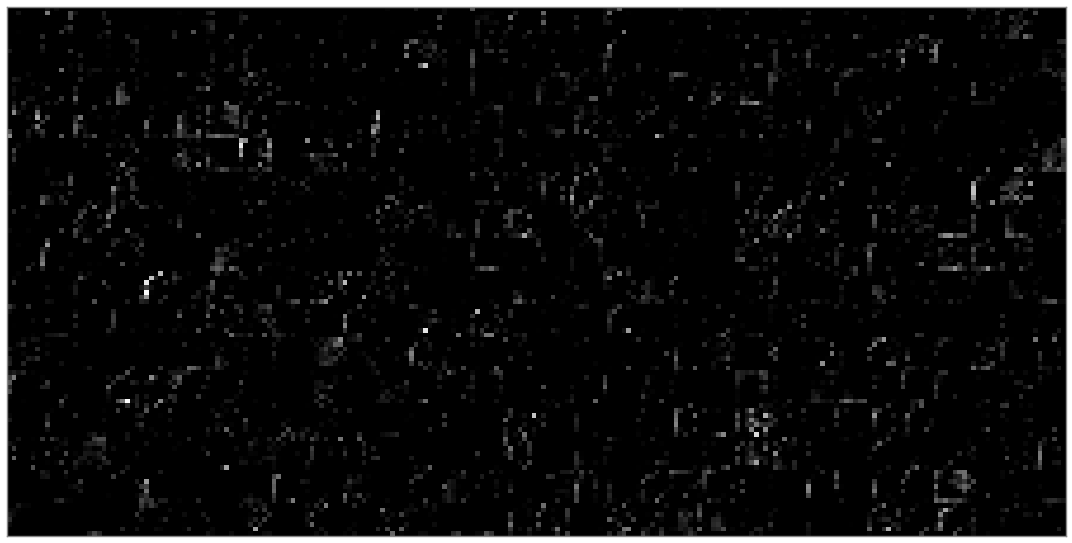

In [18]:
sample_img = data.next_batch(1, dilution=3, mode='valid')[0]
with tf.Session() as sess:
    restore_checkpoint(sess)
    conv_act = sess.run(conv_activations, {x: sample_img, training:False})

plot_images(sample_img*0.5+0.5)
for conv_act_layer in conv_act:
    plot_images(merge(np.swapaxes(conv_act_layer, 0, 3)))

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


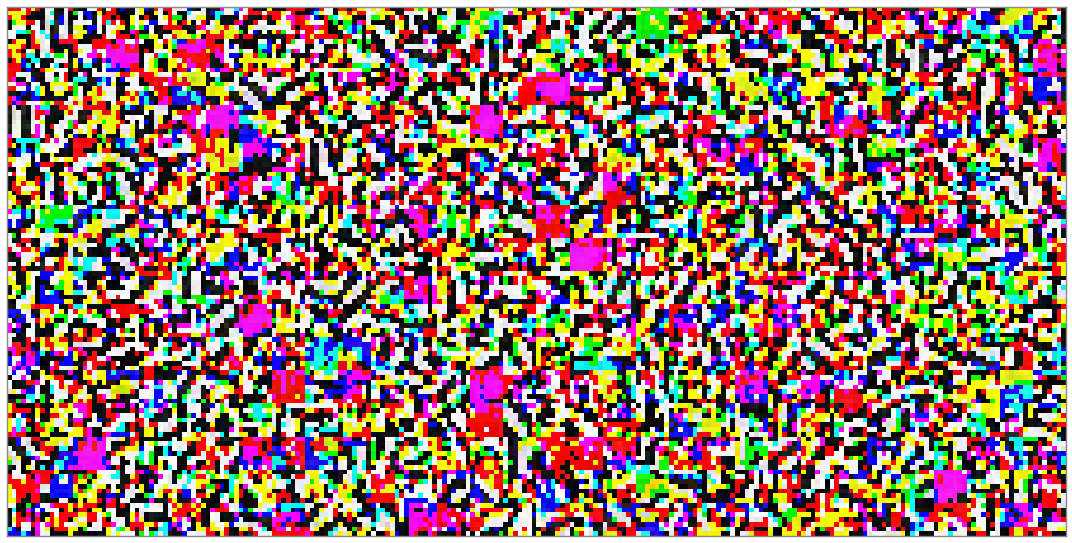

In [19]:
with tf.Session() as sess:
    restore_checkpoint(sess)
    conv_weights = sess.run([v for v in tf.trainable_variables() if v.name == 'classifier/conv1/kernel:0'][0])
    
plot_images(merge(np.rollaxis(conv_weights, 3)))

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


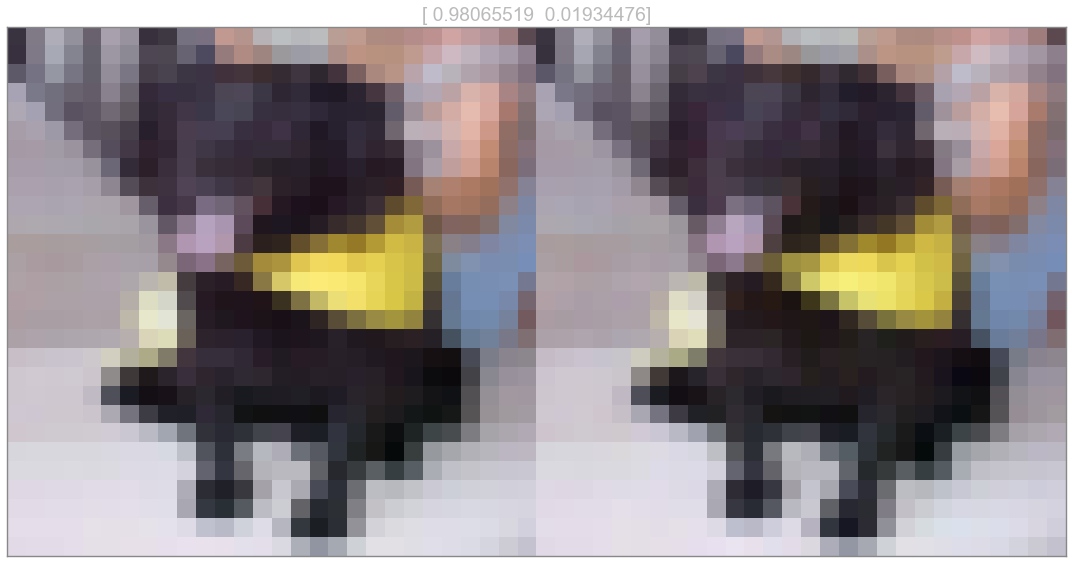

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


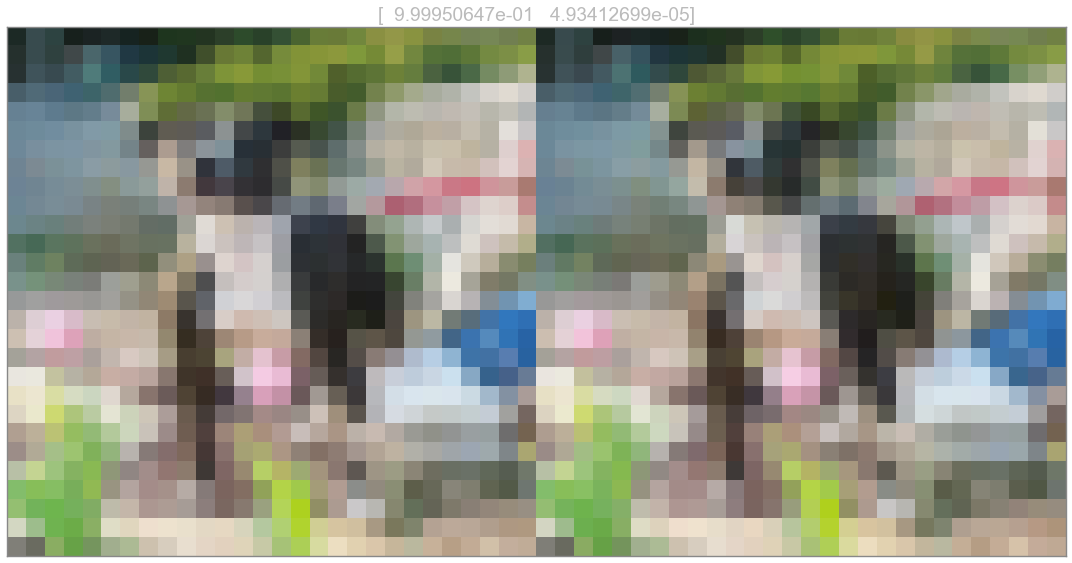

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


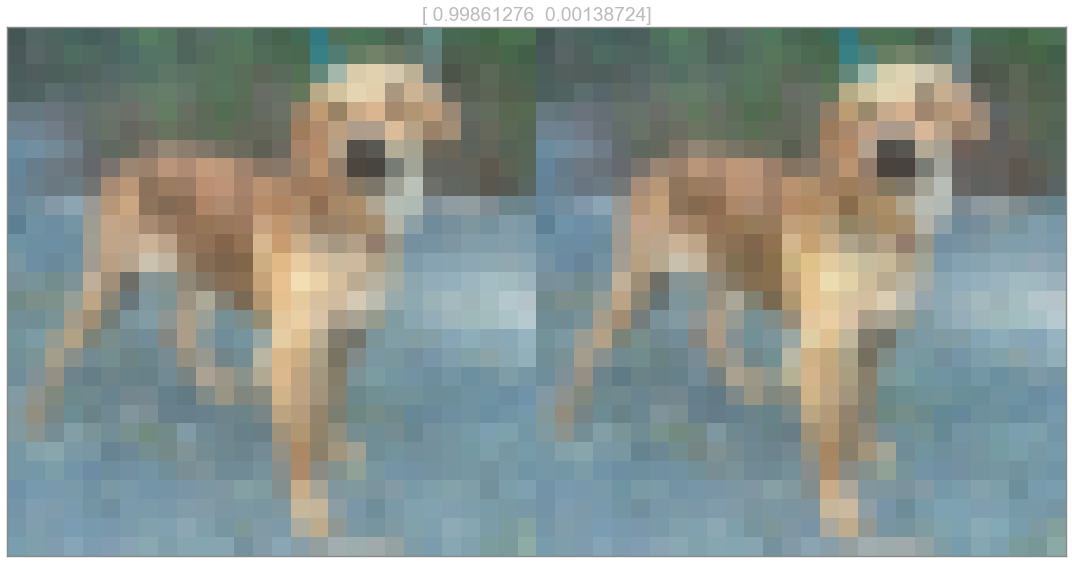

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


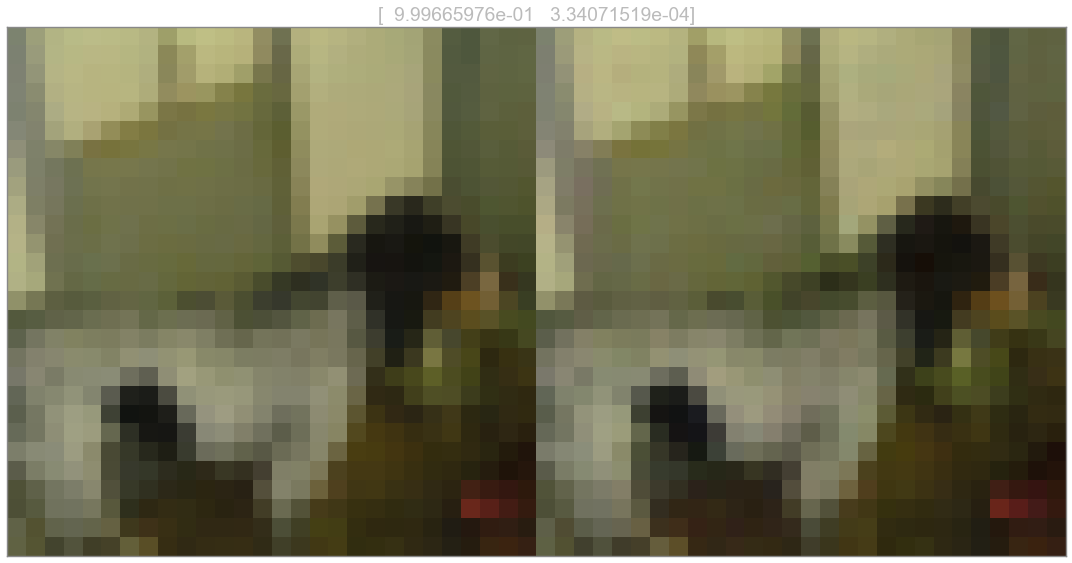

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


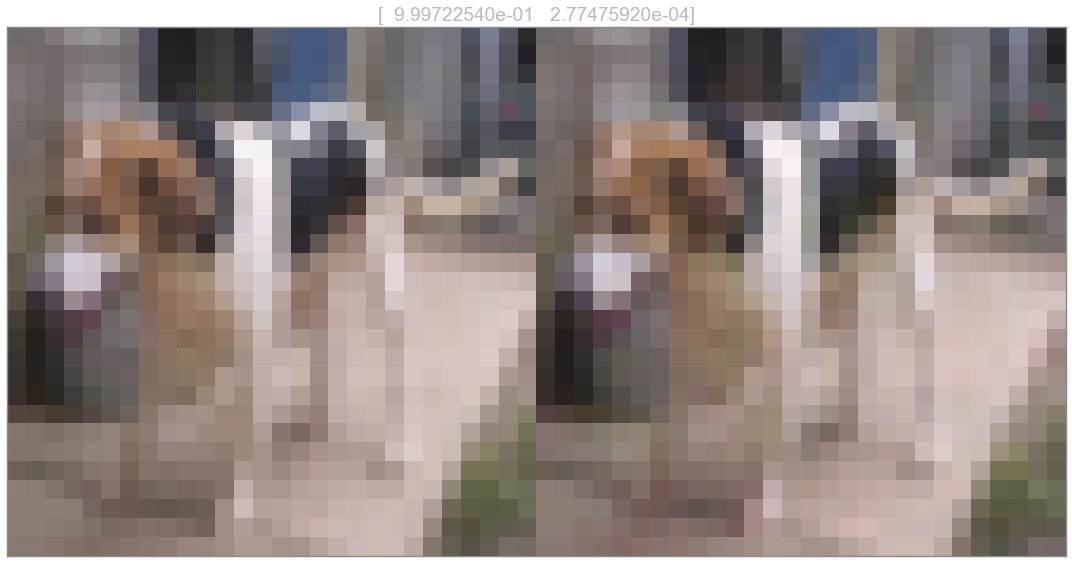

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


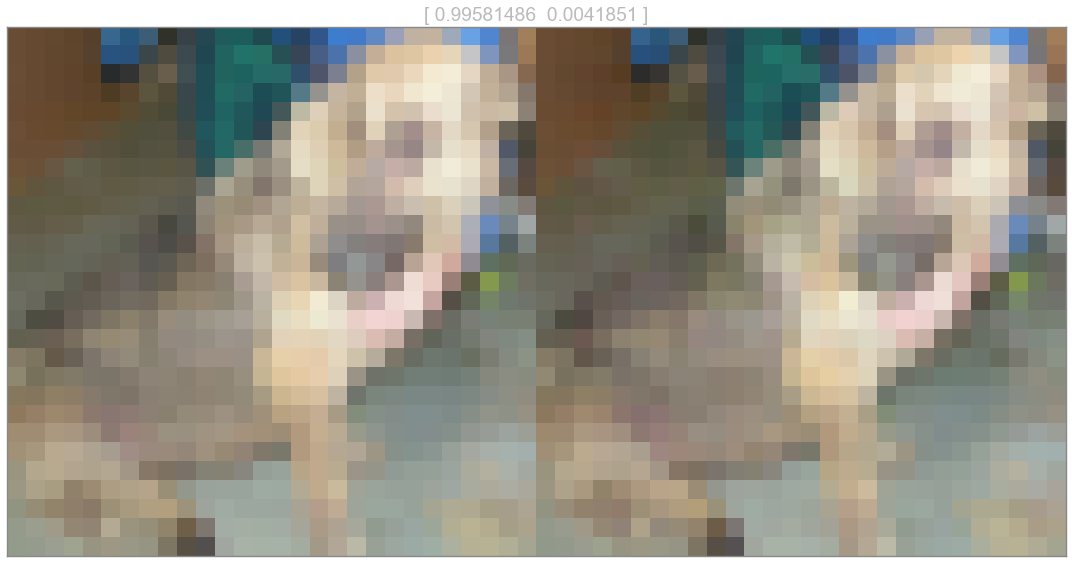

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


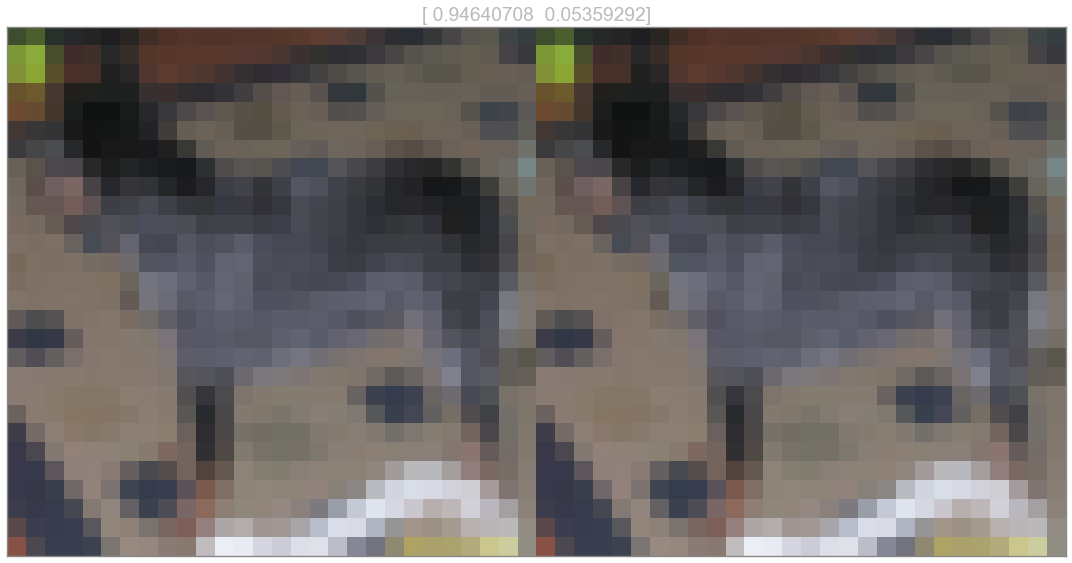

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


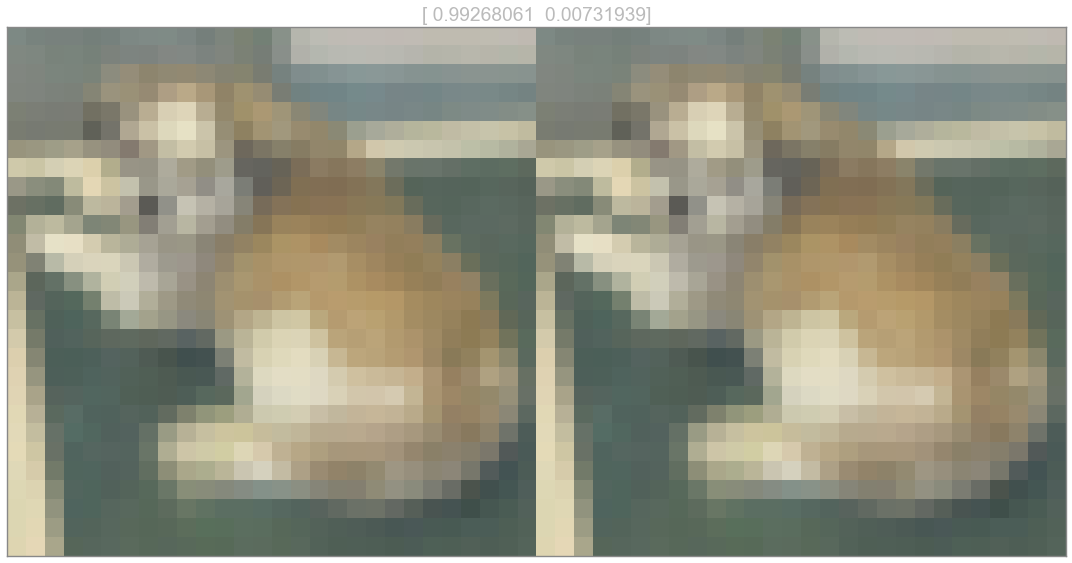

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


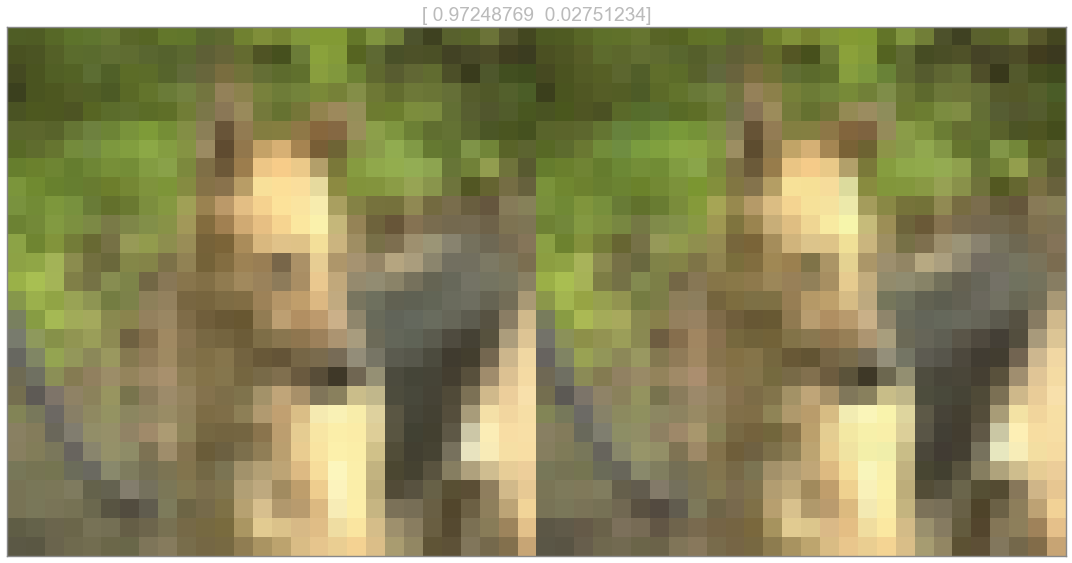

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


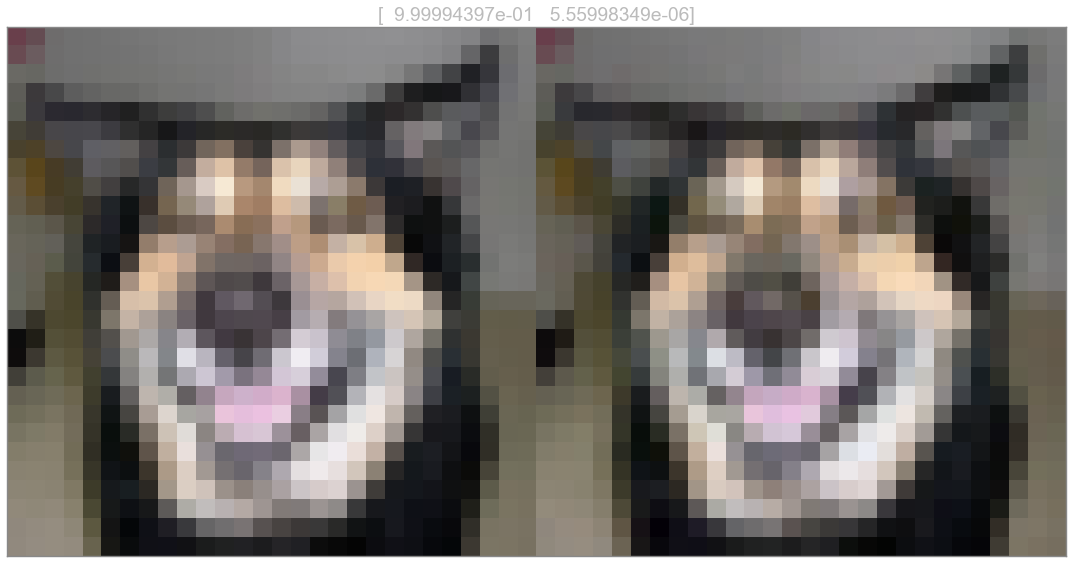

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


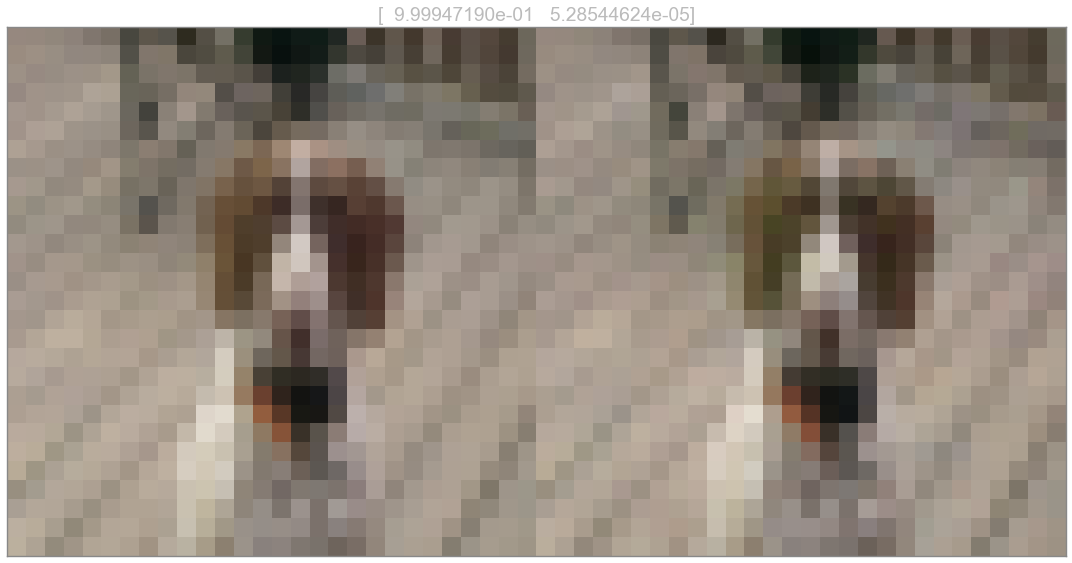

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


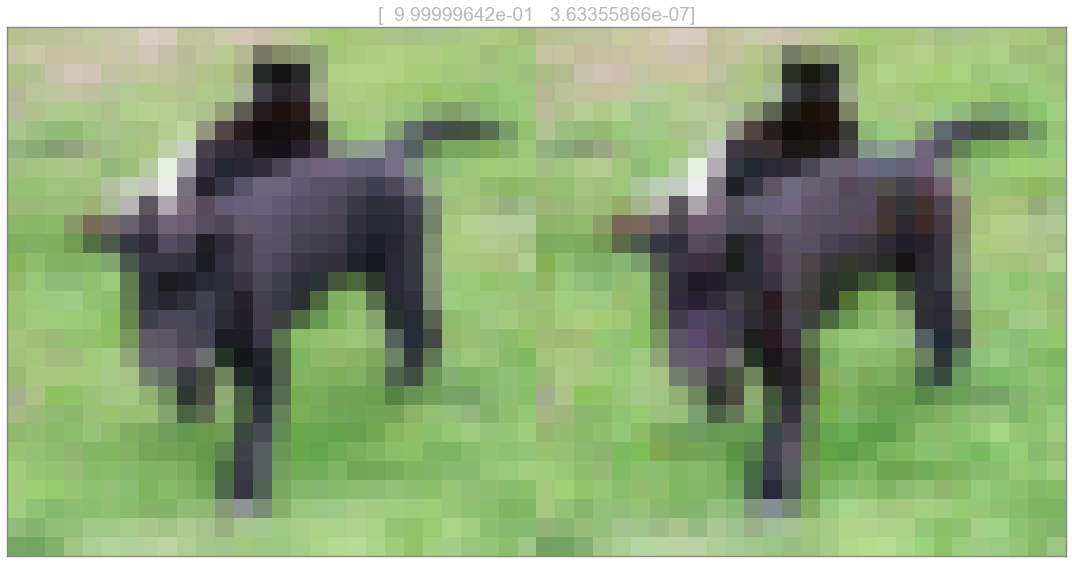

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


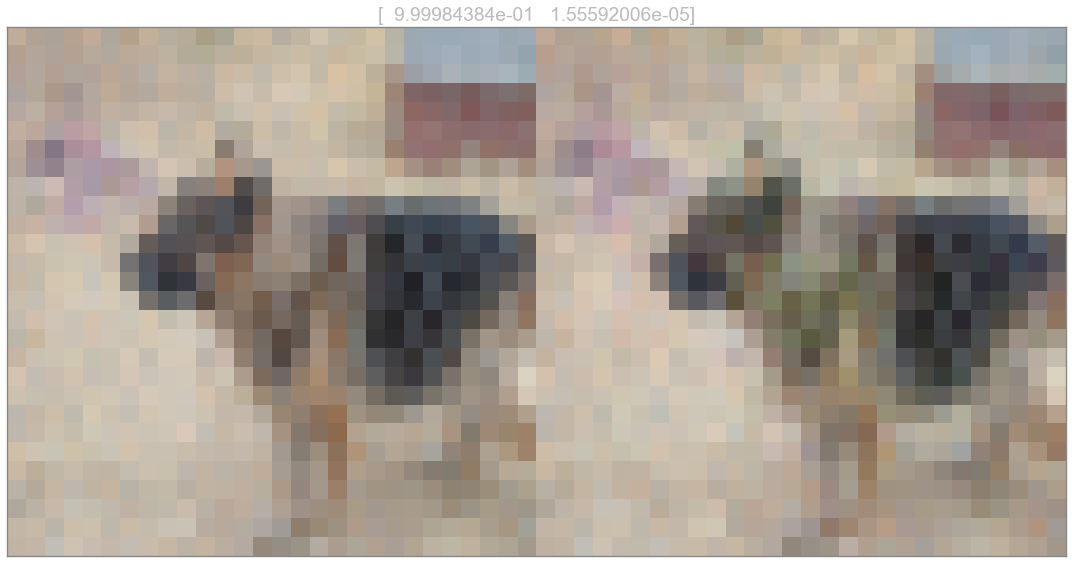

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


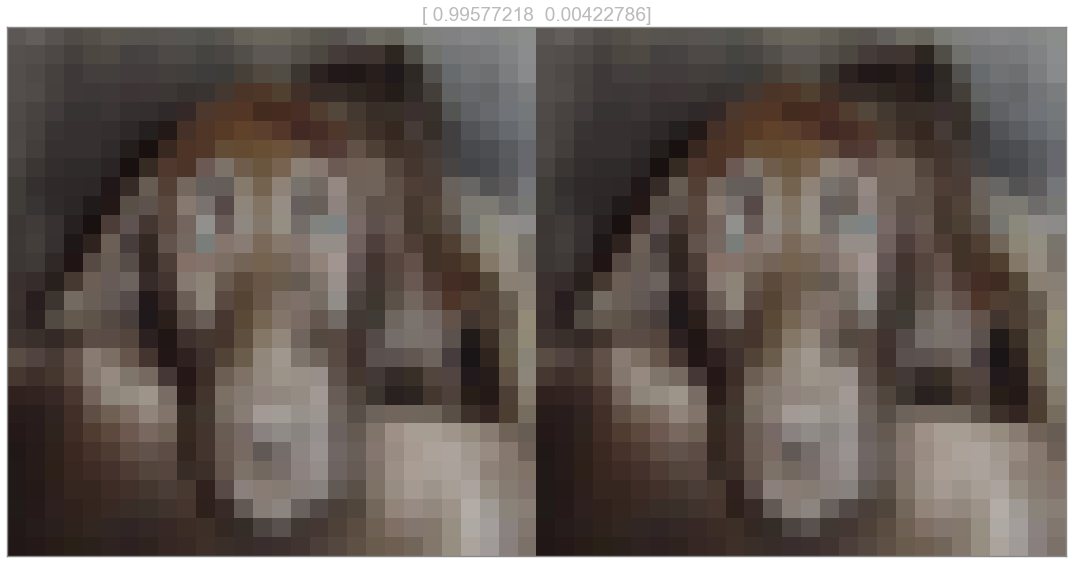

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


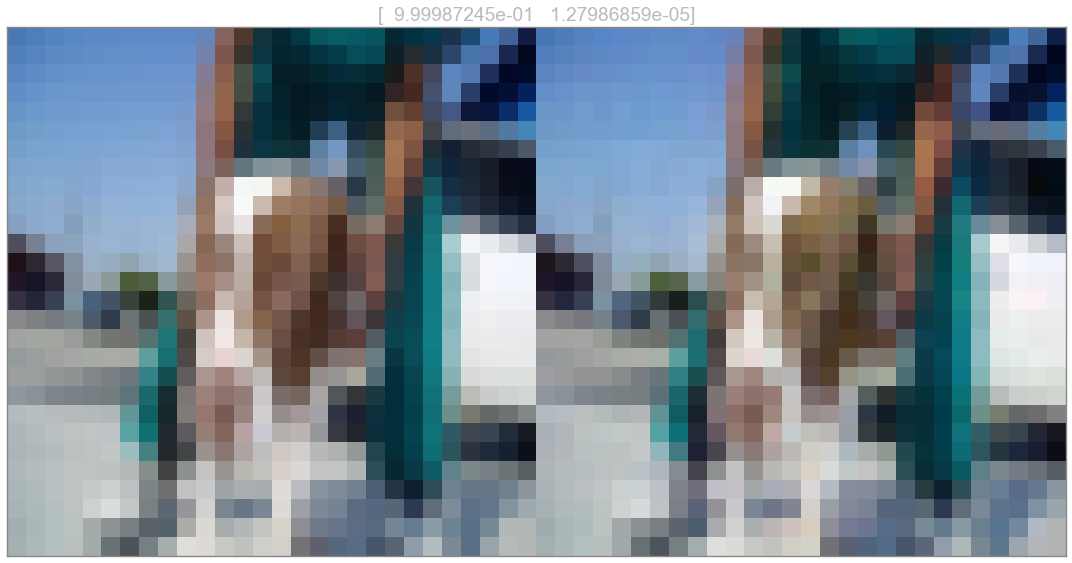

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


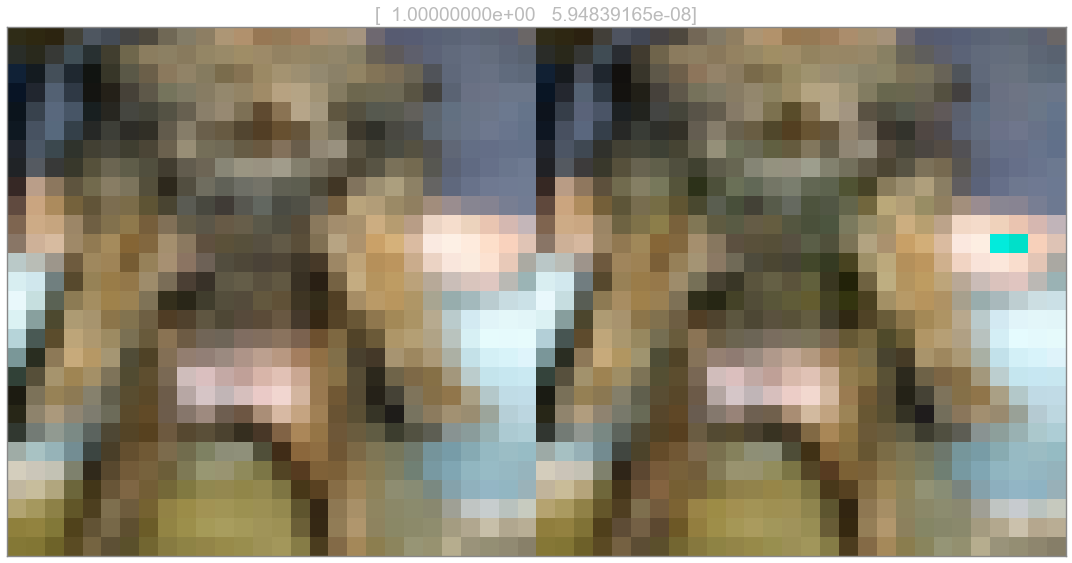

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


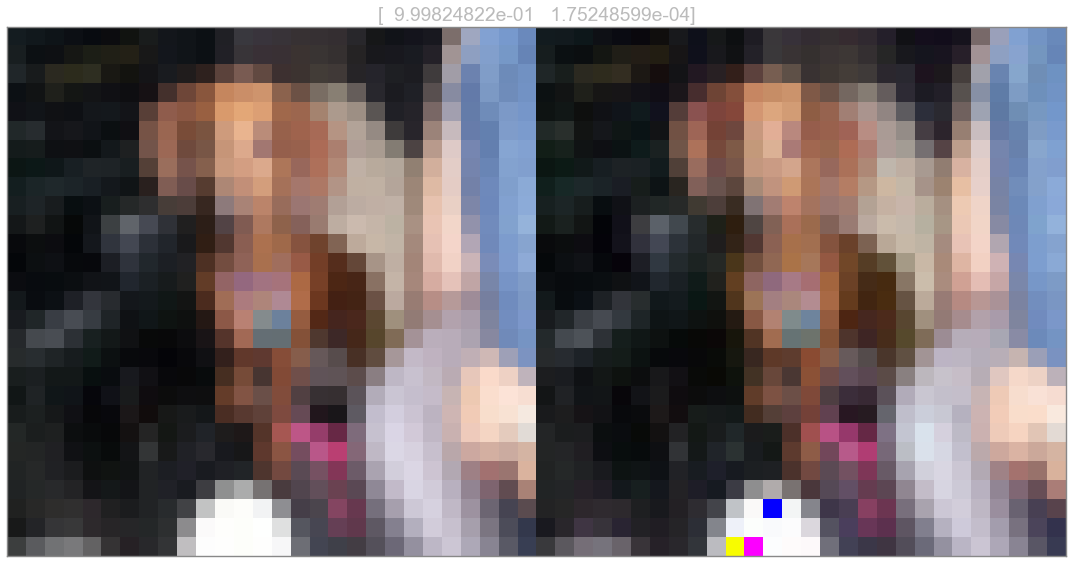

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


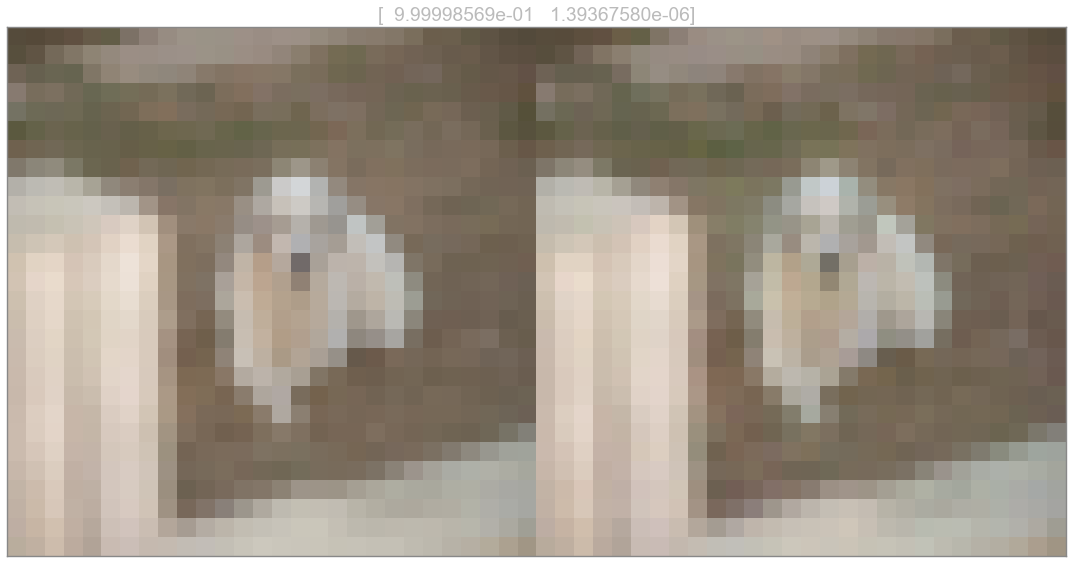

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


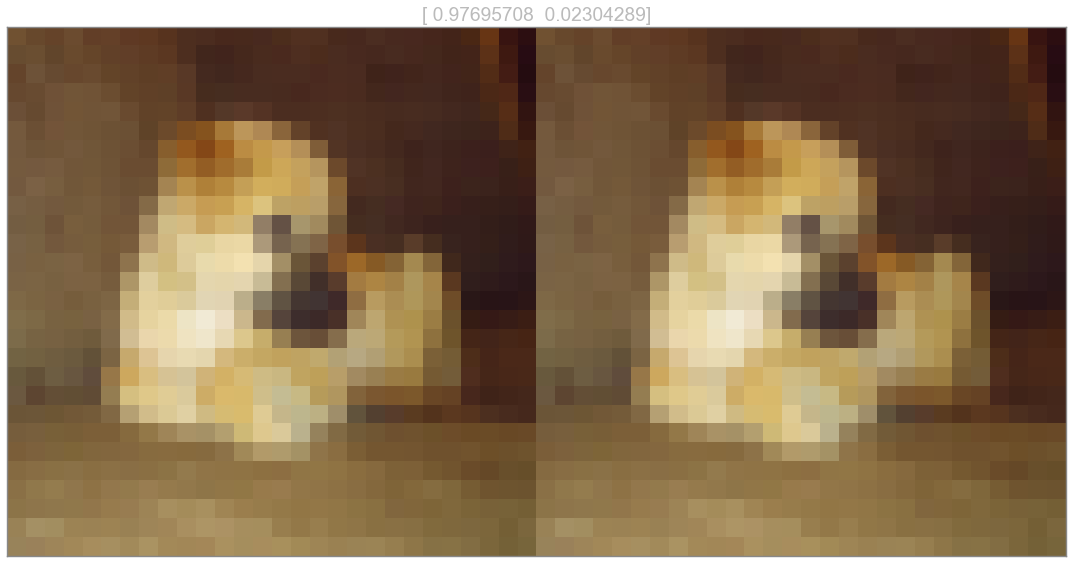

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


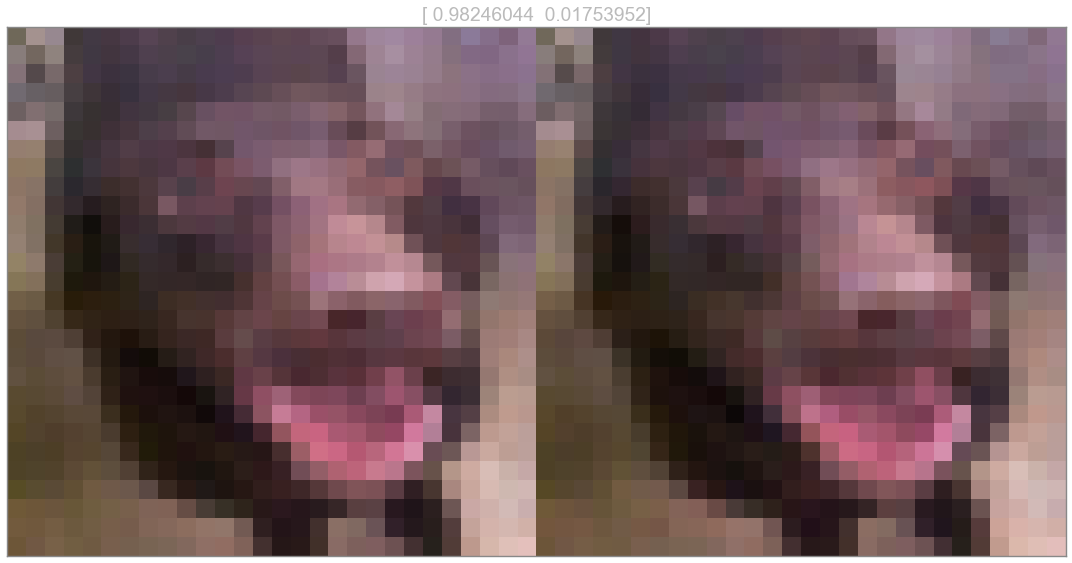

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


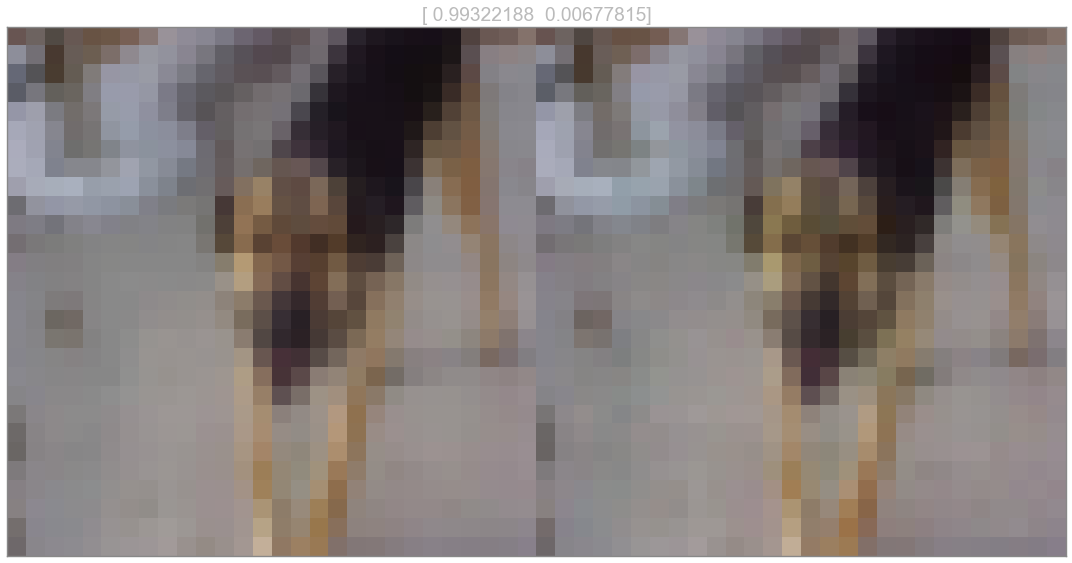

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


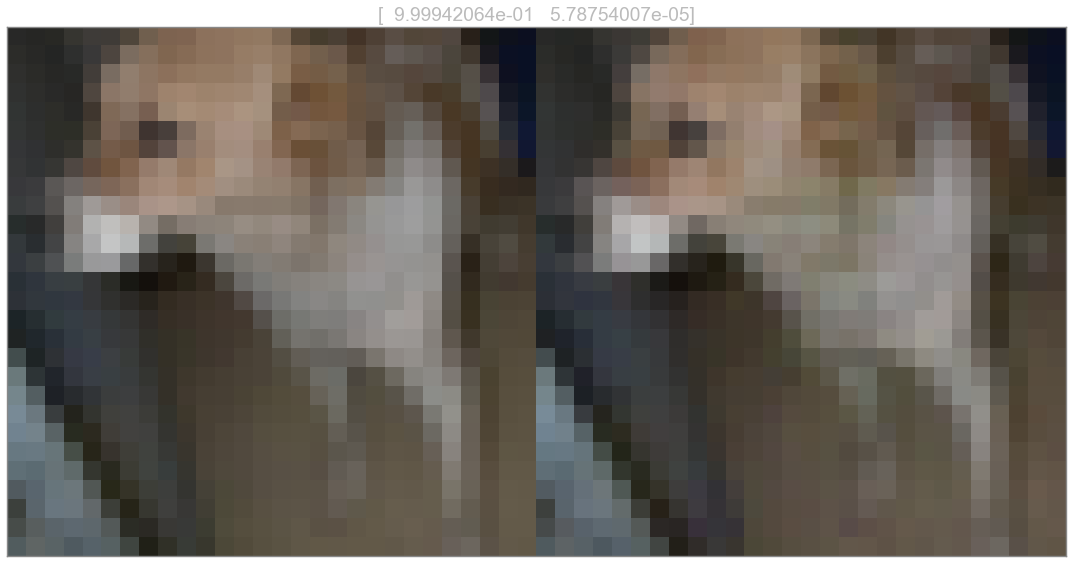

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


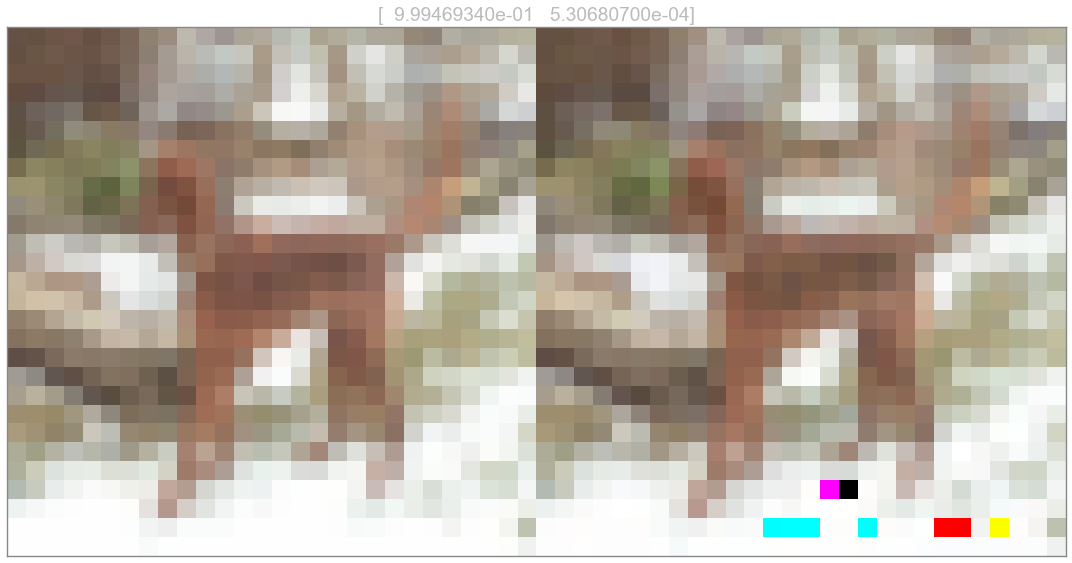

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


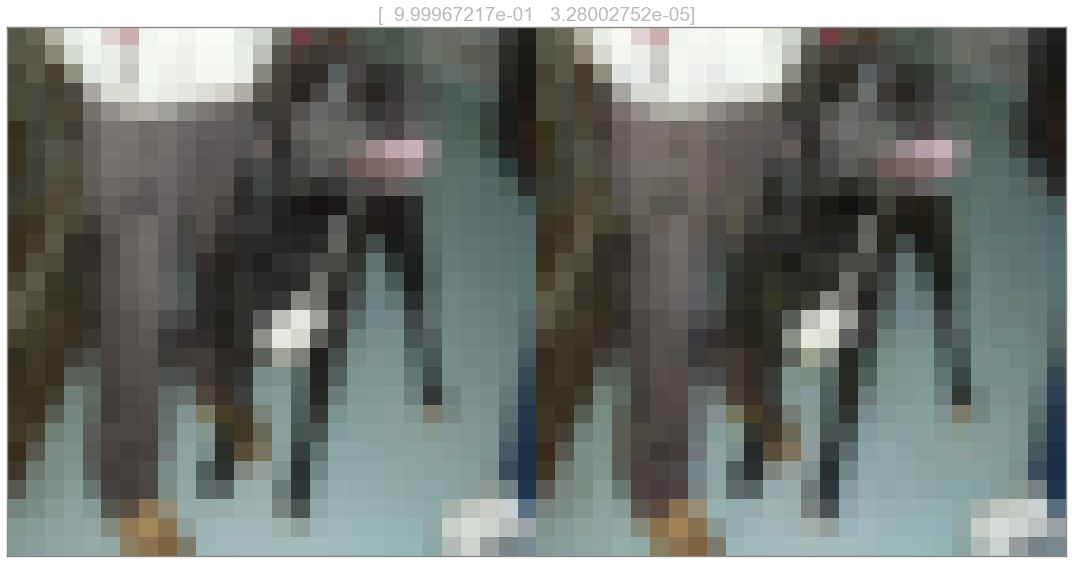

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


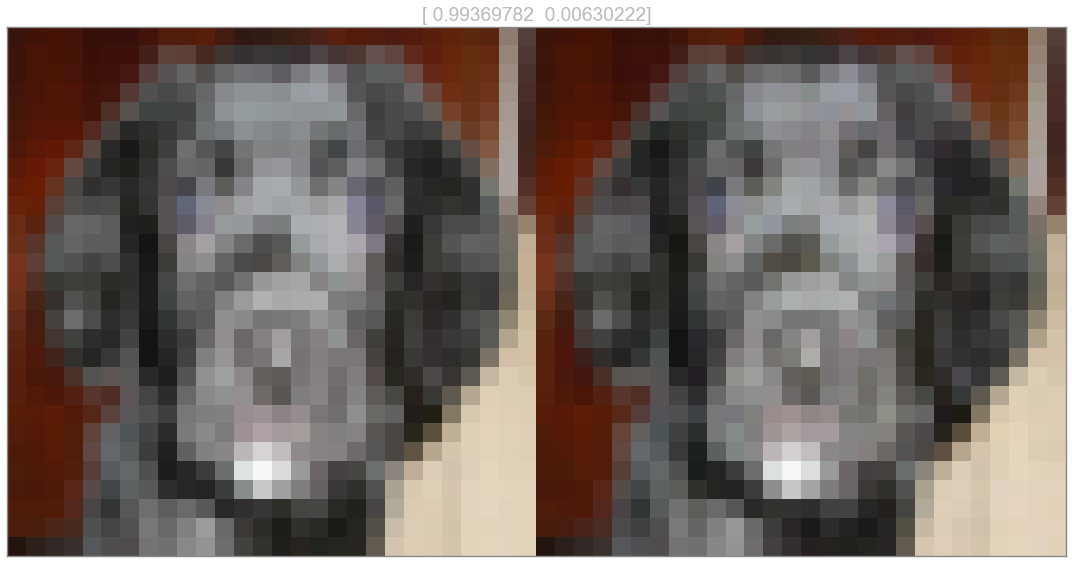

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


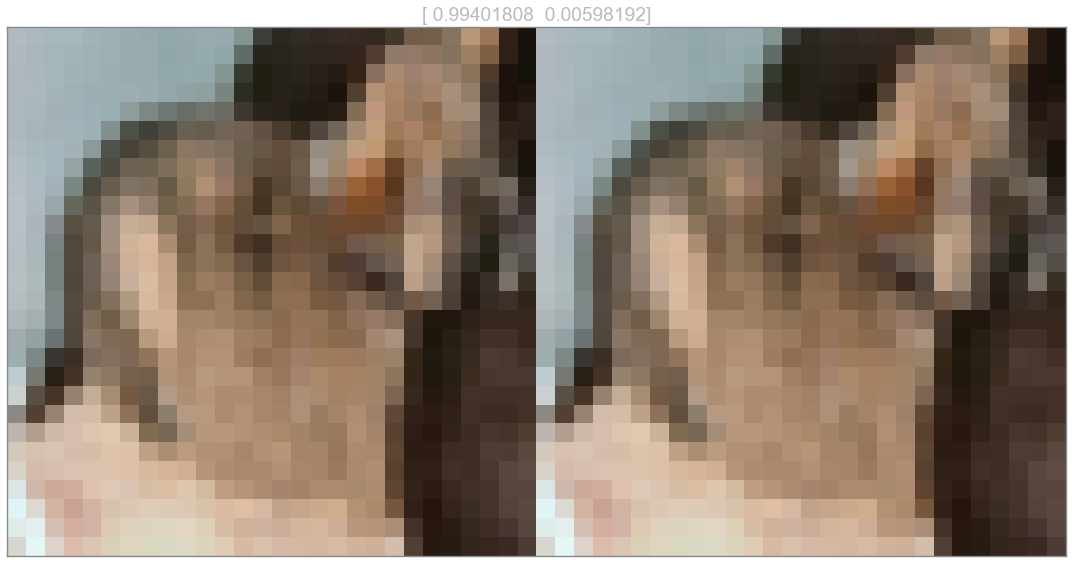

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


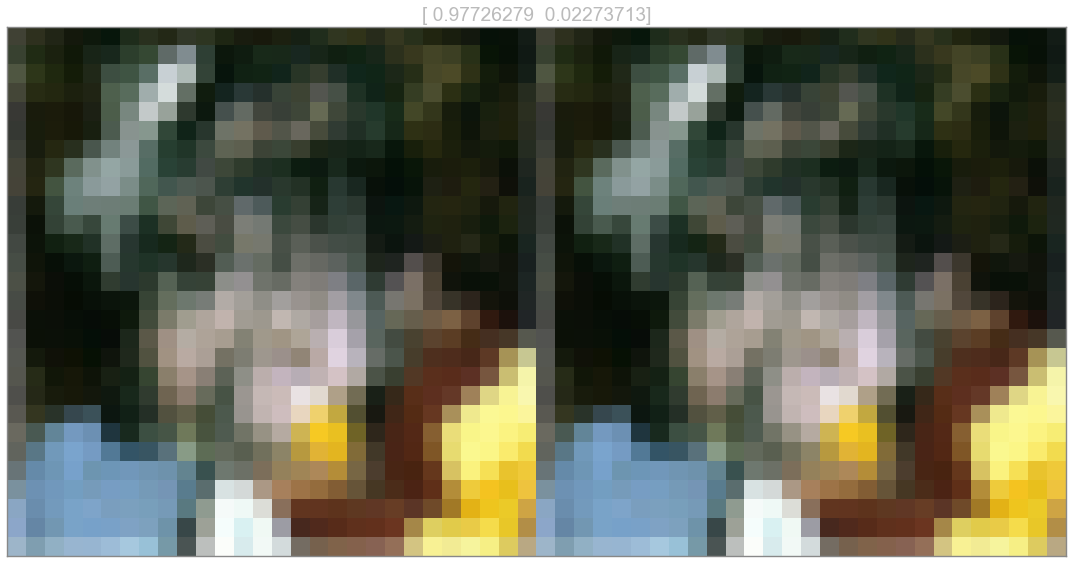

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


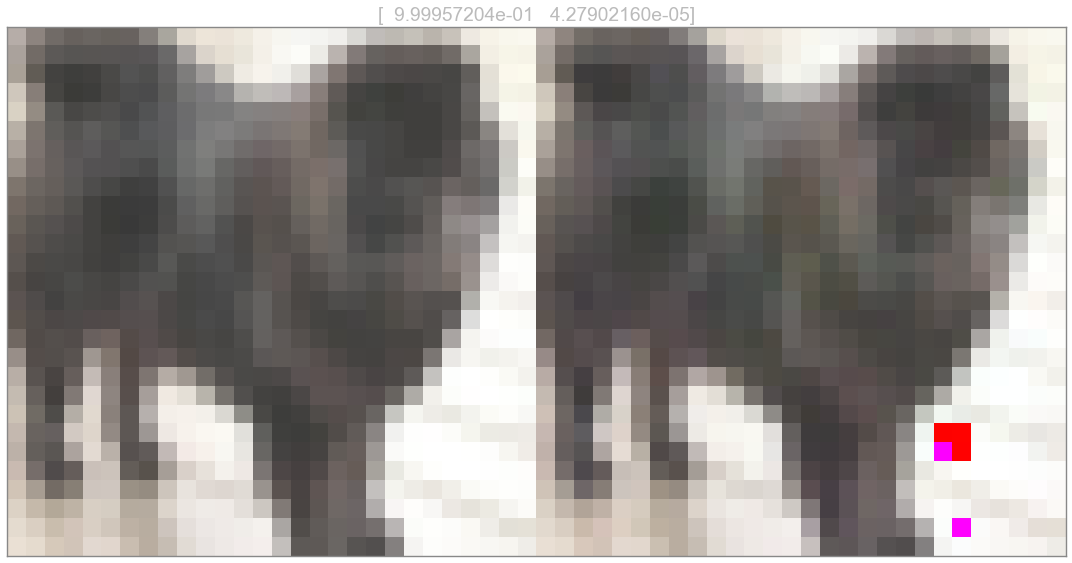

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


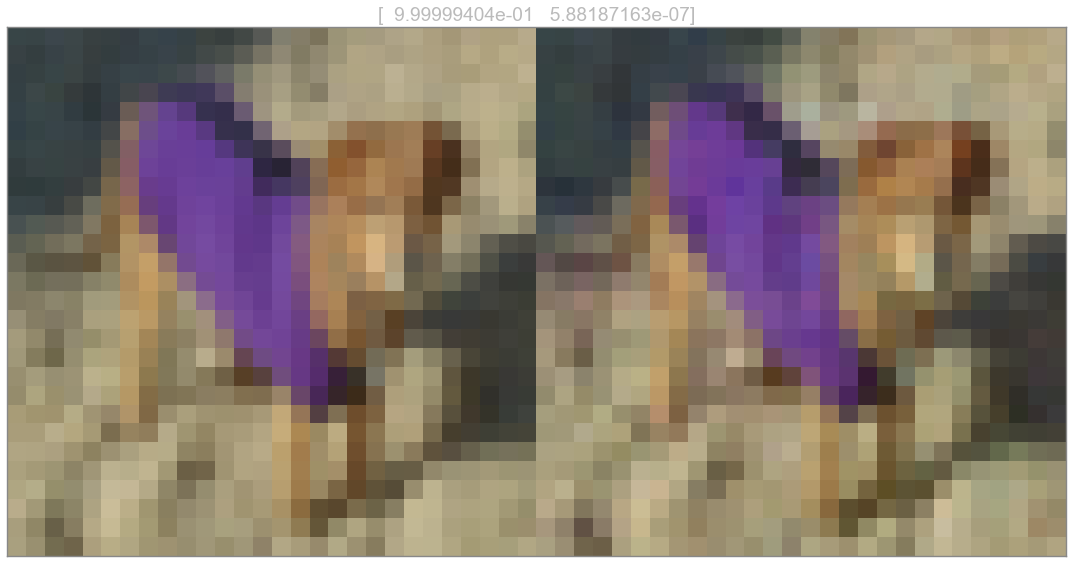

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


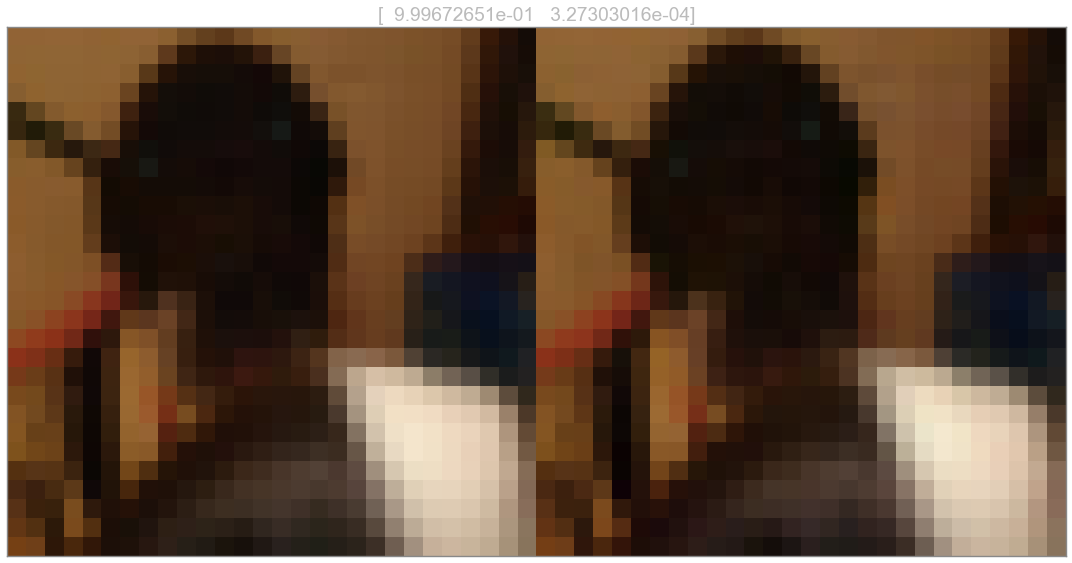

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


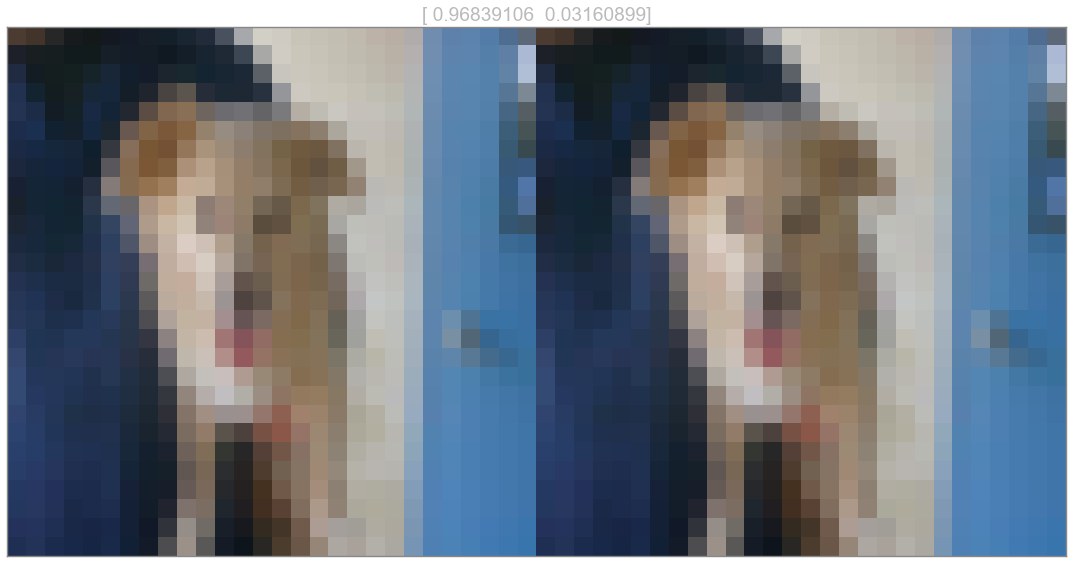

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


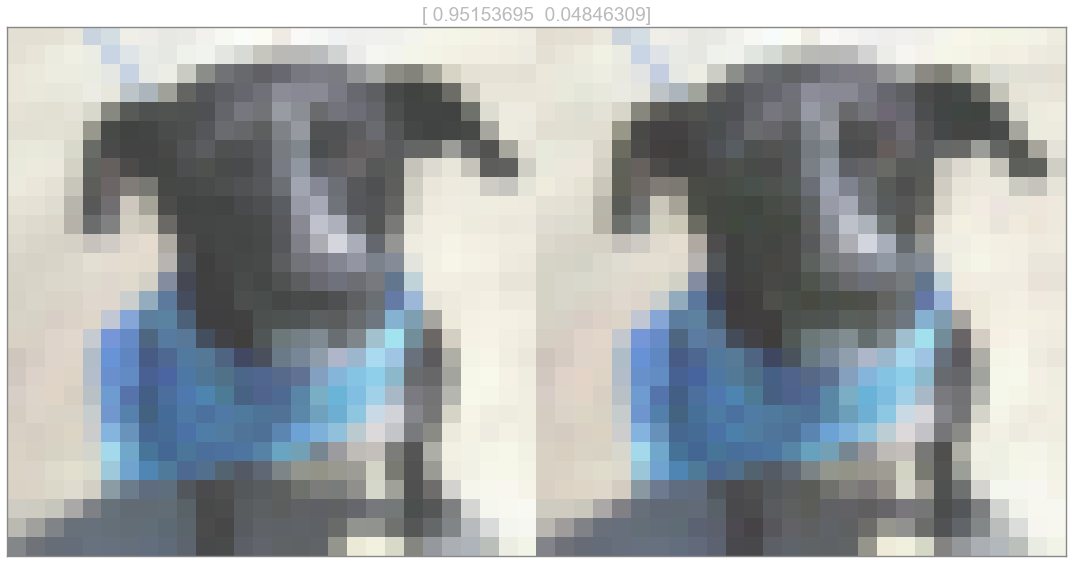

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


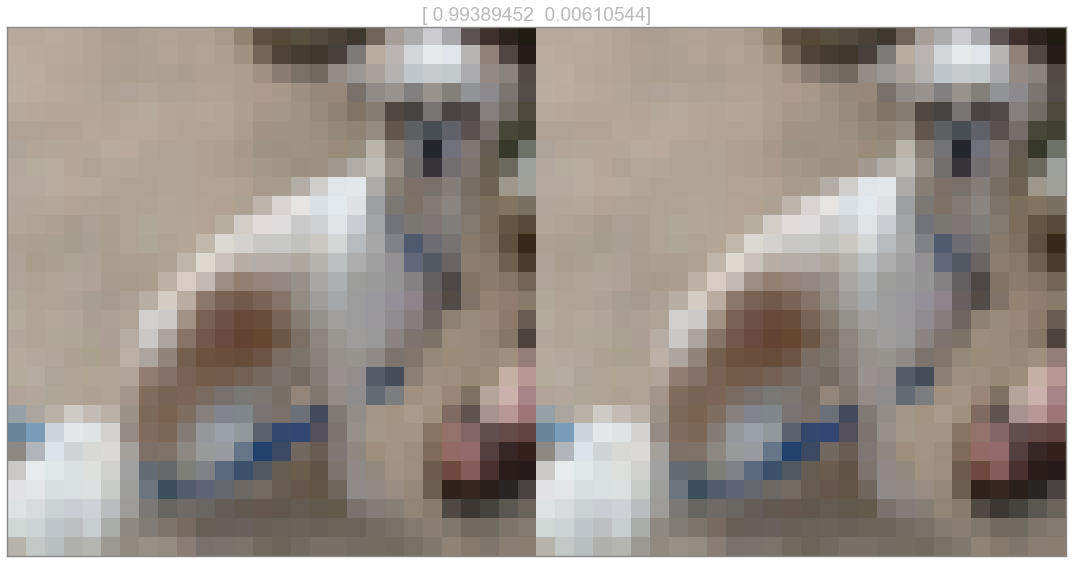

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


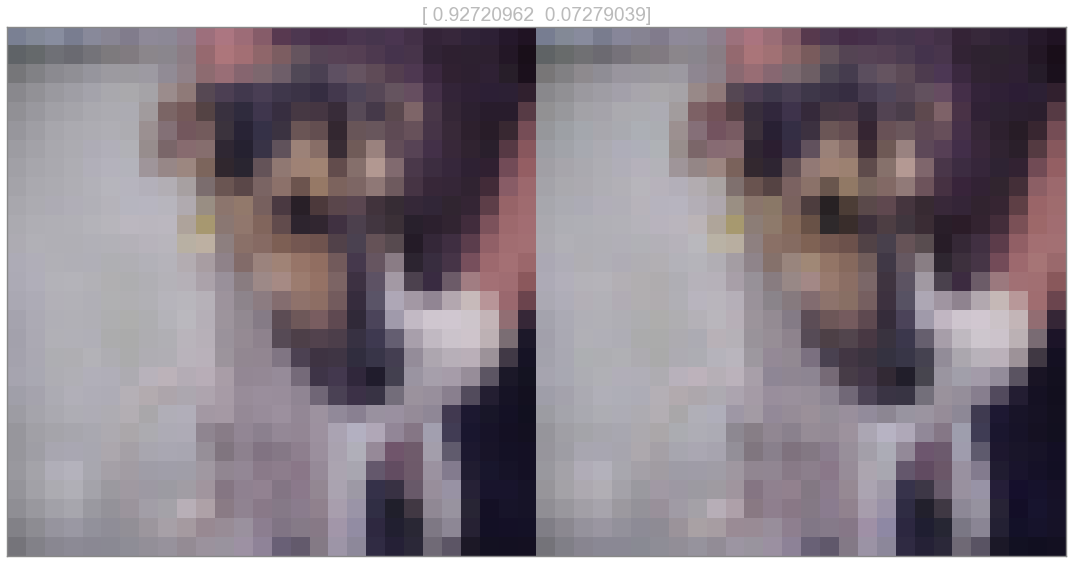

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


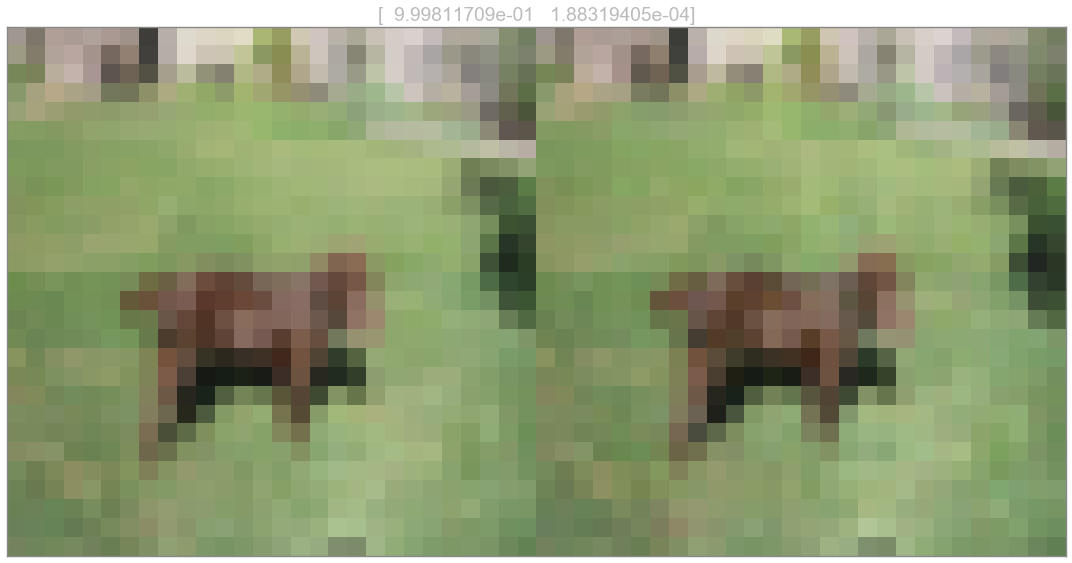

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


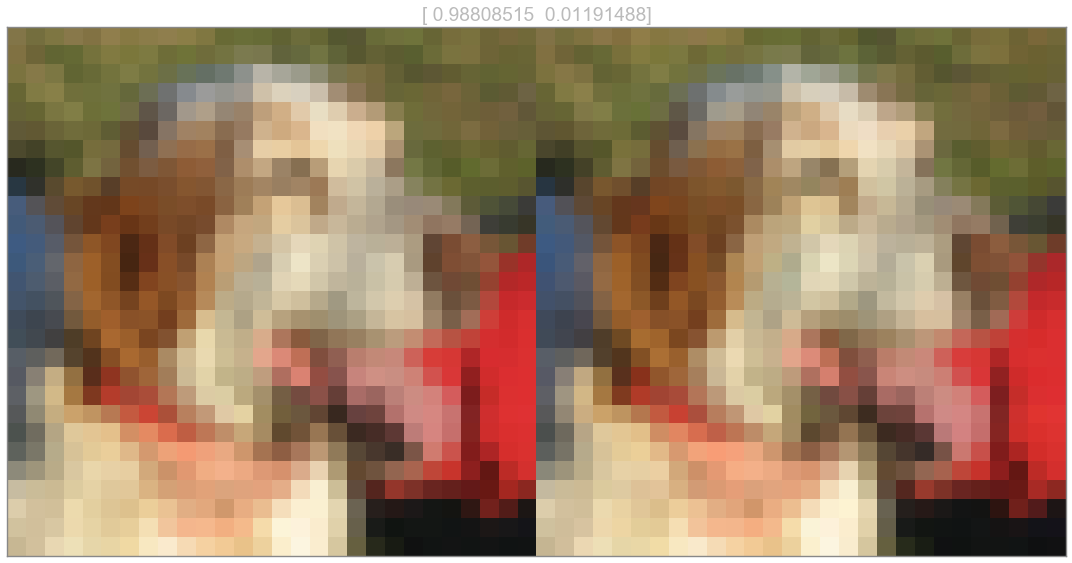

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


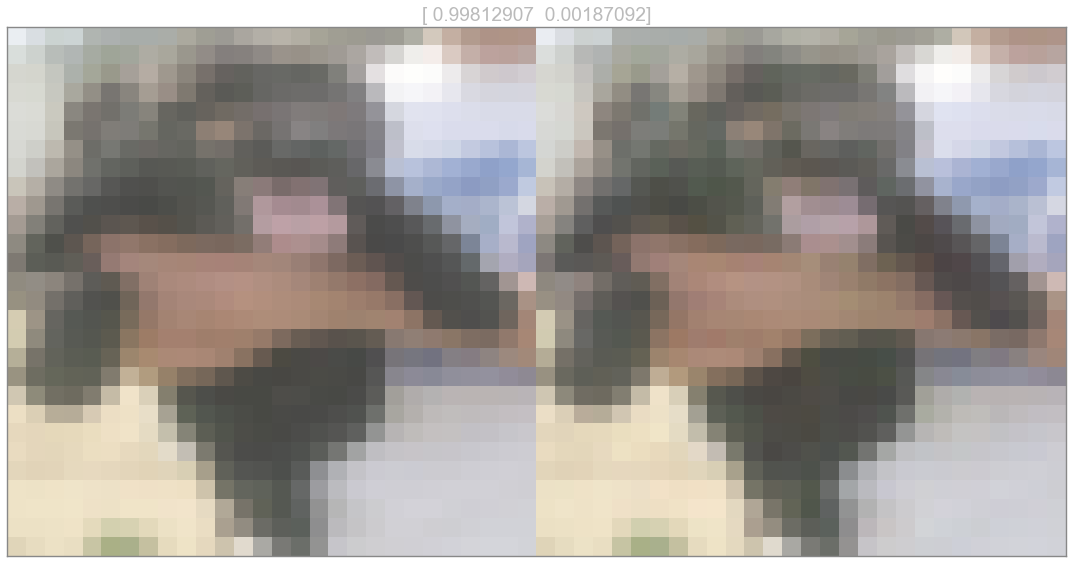

INFO:tensorflow:Restoring parameters from /home/vaisakh/TensorFlow-Tutorials/checkpoints/CatDog-Fuzzy/CatDog-Fuzzy


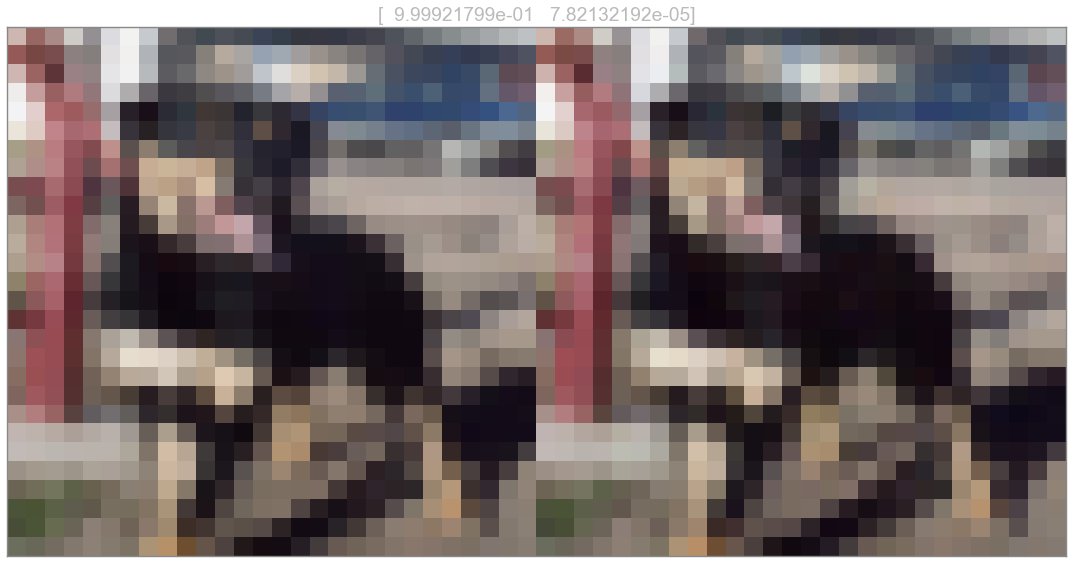

In [92]:
for _ in range(100):
    sample_img_original, original_label = data.next_batch(1, dilution=3, mode='valid')
    sample_img = np.copy(sample_img_original)
    if original_label.argmax() == 1:
        with tf.Session() as sess:
            restore_checkpoint(sess)
            for _ in range(10):
                d_cat, label = sess.run([img_grad_cat[0], y_true], {x: sample_img})
                if label[0, 0] > 0.9:
                    break
                sample_img += 1e-1*d_cat
            plot_images(merge(np.vstack([sample_img_original, sample_img])*0.5+0.5, (1, 2)), label)